# TO DO
* IMAGE SIZE - 512 * 64 (why?)
* try spectogram: chromagram (raw waveforms (not a spect.))
* try transformer

* TRY NORMALISE THE CHROMAGRAM
* SR - TRY TO TAKE SR VALUES FROM THE DATASET


* SIMPLE BASENET
* IMPROVE VAE NET
* LOOK INTO NSCNET ALTERNATIVES
* LOOK INTO METRIC LEARNING AND SIMILARITY RETRIEVAL

# TO ASK THE TUTOR
nscnet, go over the padding part and understand if what we're doing is correct

# look at the data
analyze duration, understand how big to make the chromagram images

    the images are the same size, but the same amount of of time is different in different signals
    
    let's choose a threshold where to truncate and pad
    
analyze frequencies, are there frequencies we should cut

    is there noise we should cut (we don't think so)
    
do the chromagram

# Utils

* https://analyticsindiamag.com/a-tutorial-on-spectral-feature-extraction-for-audio-analytics/

* https://ridakhan5.medium.com/audio-clustering-with-deep-learning-a7991d605fa5

* https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

* https://www.researchgate.net/publication/333427516_Feature_Learning_for_Bird_Call_Clustering

* https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225

* https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

* https://musicinformationretrieval.com/kmeans.html

* Feature Normalization: https://www.hackaudio.com/digital-signal-processing/amplitude/peak-normalization/#:~:text=Normalizing%20the%20amplitude%20of%20a,magnitude%20equals%20a%20specified%20level.&text=This%20opens%20in%20a%20new%20window.&text=Peak%20amplitude%20is%20a%20measurement%20based%20the%20instantaneous%20level%20of%20a%20signal.

* https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S1_FeatureNormalization.html

* https://stackoverflow.com/questions/48257311/signal-processing-can-someone-explain-for-me-the-different-type-of-spectrogram

* https://www.geeksforgeeks.org/plotting-a-spectrogram-using-python-and-matplotlib/

* https://it.mathworks.com/matlabcentral/answers/319352-how-do-i-perform-clustering-of-audio-signal

wav files seconds
* https://stackoverflow.com/questions/13039846/what-do-the-bytes-in-a-wav-file-represent

In [245]:
#!pip install librosa
from pathlib import Path
import os
import pandas as pd
import librosa
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, sosfiltfilt

In [4]:
#constants
SR = 22050

In [5]:
DIR = './dataset/songs_extracted'

In [6]:
#function that loads the songs from the songs_extracted dataset
def load_songs_extracted(directory):
    data = []
    for bird_names in os.listdir(directory)[:1]:
        path_bird_names = os.path.join(directory, bird_names)
        if os.path.isdir(path_bird_names):
            for channel in os.listdir(path_bird_names):
                if channel == "CH2":
                    path_channel  = os.path.join(path_bird_names, channel)
                    if os.path.isdir(path_channel):
                        for song in  os.listdir(path_channel):
                            song_num = int(re.search('\d+', song).group())
                            path_song = os.path.join(path_channel, song)
                            signal, sr = librosa.load(path_song)
                            data.append([bird_names, song_num, sr, signal]) #channel is CH2 by default

    # return dataframe creation
    return pd.DataFrame(data, columns=['bird', 'song', 'sr', 'signal'])

In [7]:
df = load_songs_extracted(Path(DIR))
df.head()

,bird,song,sr,signal
0,andrei_bos,1,22050,"[8.5976695e-05, 2.9542274e-05, 1.942474e-05, 6..."
1,andrei_bos,10,22050,"[-0.0036385355, -0.0036303482, 0.00060955447, ..."
2,andrei_bos,100,22050,"[0.0046478678, 0.0069209742, 0.0035229707, -1...."
3,andrei_bos,101,22050,"[0.0035249959, 0.004198667, 0.0008914086, -0.0..."
4,andrei_bos,102,22050,"[-0.004434305, -0.0046334974, -0.0007038029, 0..."


In [8]:
df.shape

(125, 4)

In [9]:
print(df['signal'][0].shape)
print(df['signal'][0])

(100479,)
[ 8.5976695e-05  2.9542274e-05  1.9424740e-05 ... -6.7224988e-04
 -8.3629106e-04  1.2994485e-04]


In [181]:
import IPython.display as ipd
ipd.Audio(df.iloc[0]['signal'], rate=SR)

# Preprocessing

truncation: understand if having signals of different length is a problem

normalization: understand how and if to normalize (-1,1)

### Padding

In [178]:
df['signal_length'] = df['signal'].apply(lambda x: len(x))
mean = np.mean(df['signal_length'])
mean = int(mean)
print('mean:', mean)
print('standard deviation:', np.std(df['signal_length']))
print(df[df['signal_length'] < 100000]['signal_length'].count(), 'signals are not truncated out of', df['signal_length'].count())

policy = 'truncation' #'padding'

if policy == 'padding':
    maxim = np.max(df['signal_length'])
    print(maxim)
    df['padded_signal'] = df['signal'].apply(lambda x: np.pad(x, (0, maxim-len(x))) )
    
elif policy == 'truncation':
    #TODO truncation
    trunc_thresh = 11*22050  #maxim
    #padding
    df['padded_signal'] = df['signal'].apply(lambda x: np.pad(x, (0, trunc_thresh-len(x))) if len(x)<trunc_thresh else x) 
    #truncation
    df['padded_signal'] = df['padded_signal'].apply(lambda x: x[0:trunc_thresh] if len(x)>trunc_thresh else x) 
    
print(len(df['padded_signal'][1]))

mean: 80078
standard deviation: 33022.80661310398
102 signals are not truncated out of 125
242550


### Amplitude Normalization
if we want to normalize the signals using their own max value for each, we don't need to do it
cause the chromagram ALREADY DOES IT

we can try to normalize all the signals together using the highest value in all the dataset
so the relationships between signal amplitudes is kept

here we are doing the first method

In [216]:
df['normalized_signal'] = df['padded_signal'].apply(lambda x: x/np.max(np.abs(x)))
print(np.max(np.abs(df['normalized_signal'][0])))

1.0


### Filtering

In [263]:
sr = SR     
order = 5
lf = 1500
filtered = []
def high_pass(sig):
    nyq = sr/2
    sos = butter(order, [lf/nyq], analog=False, btype='highpass', output='sos')
    return sosfiltfilt(sos,sig)

df['filtered_signal'] = df['padded_signal'].apply(lambda x: high_pass(x))    

### Chromagrams

In [264]:
chromagrams = []
for signal in df['filtered_signal']:
    chrom = librosa.feature.chroma_stft(y=signal, sr=SR)
    chromagrams.append(chrom)
    
#chromagrams = df['normalized_signal'].apply(lambda x: librosa.feature.chroma_stft(y=x, sr=SR))

In [258]:
#chromagrams

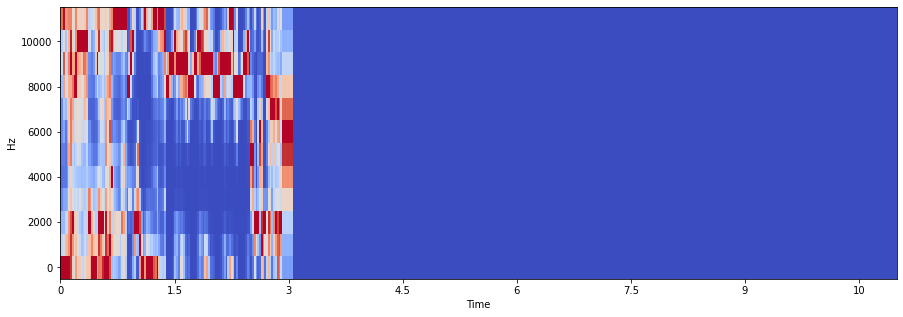

In [265]:
import librosa.display
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagrams[2], x_axis='time', y_axis='hz', hop_length=512, cmap='coolwarm')

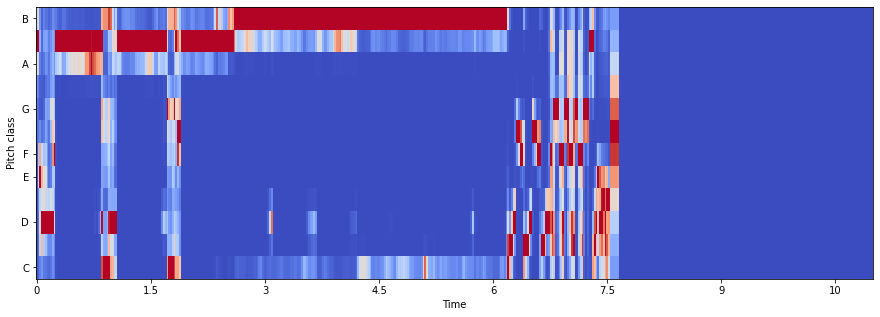

In [266]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagrams[120], x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

In [170]:
chromagrams[2].shape

(12, 293)

In [171]:
zero_crossings = []
for signal in df['signal']:
    zc = librosa.feature.zero_crossing_rate(y=signal)
    zero_crossings.append(zc)

In [16]:
def feature_normalisation(df: pd.DataFrame):
    df_norm = df.copy()
    #normalisation
    
    return df_norm